In [184]:
import numpy as np
import pandas as pd
import s3fs
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Concatenate
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from typing import List, Set, Dict, Tuple, Optional, Iterable, Callable
import pyarrow
import boto3
import pyarrow.parquet as pq
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score

In [2]:
pd.options.display.float_format = '{:20,.3f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.max_colwidth', 0)
s3 = s3fs.S3FileSystem()

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # wide notebook display

In [4]:
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
physical_device = tensorflow.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}')

Device found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))
tensorflow.test.is_gpu_available()
!python3 --version

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7174372355626862922
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15345647616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18300739893557980426
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0"
xla_global_id: 416903419
]
2.7.0
Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Python 3.7.10


In [7]:
feature_path = 's3://aap-aiexpzone-pii-mktg-datascientist-results-prod/ScottSmith/may_2021_page_action_no_leakage.parquet'

In [8]:
feature_table = pq.ParquetDataset(feature_path, filesystem=s3).read_pandas().to_pandas()

In [9]:
len(feature_table)

5801003

In [10]:
feature_table.columns

Index(['udo_tealium_session_id', 'TYPE_SENTENCE', 'NAME_SENTENCE',
       'CATEGORY_SENTENCE', 'ACTION_SENTENCE', 'LABEL_SENTENCE',
       'DWELL_SENTENCE', 'LABEL'],
      dtype='object')

In [11]:
feature_table.dtypes

udo_tealium_session_id    object
TYPE_SENTENCE             object
NAME_SENTENCE             object
CATEGORY_SENTENCE         object
ACTION_SENTENCE           object
LABEL_SENTENCE            object
DWELL_SENTENCE            object
LABEL                     int32 
dtype: object

In [12]:
len(feature_table.iloc[0, 1].split())

14

### Now we evaluate the class balance

In [13]:
summary = feature_table.groupby('LABEL')['udo_tealium_session_id'].count().reset_index()

In [14]:
summary['FRACTION'] = summary['udo_tealium_session_id']/summary['udo_tealium_session_id'].sum()

In [15]:
summary

LABEL  udo_tealium_session_id             FRACTION
0  0      5491531                               0.947
1  1      309472                                0.053

### Let's look at sequence sizes

In [16]:
feature_table['LENGTH'] = feature_table['TYPE_SENTENCE'].str.split().apply(len)

In [17]:
true_zeros = feature_table[feature_table.LABEL == 0]

In [18]:
true_ones = feature_table[feature_table.LABEL == 1]

In [19]:
true_zeros['LENGTH'].mean()

4.658235198890801

In [20]:
true_ones['LENGTH'].mean()

5.328514372867335

In [21]:
true_ones['NAME_SENTENCE'].head(100)

26      EvaporativeEmissionsVacuumSolenoidValve, VacuumsolenoidResults, VacuumsolenoidResults, VacuumsolenoidvacuumResults, VacuumResults                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
71      Homepage, Homepage, thermostatsResults, thermostatssensorResults, coolanttemperaturesensorResults, StoreLocator, temperaturesensorsResults                              

In [22]:
true_zeros['ACTION_SENTENCE'].head(100)

0      ASSYLUBE, Page, Page, ASSYLUBEGREASE, Page, Page, Page, ENGINEASSYLUBEGREASE, Page, Page, LUBERPLATEGREASE, Page, Page, l0034-094                                                                                                                                                                                                                                                                           
1      Garage, Garage, Garage, Garage, Garage, Garage, Garage                                                                                                                                                                                                                                                                                                                                                      
2      rearbrakepads, rearbrake, Page                                                                                                                                                           

#### We want the mean sequence lengths of true positives and negatives to be as close as possible to each other to avoid the model over relying on sequence length.

In [23]:
(true_zeros['LENGTH']==1).sum()/len(true_zeros)

0.18484480921622767

In [24]:
(true_ones['LENGTH']==1).sum()/len(true_ones)

0.1678988729190363

In [25]:
(true_zeros['LENGTH']==2).sum()/len(true_zeros)

0.171779600260838

In [26]:
(true_ones['LENGTH']==2).sum()/len(true_ones)

0.1228867231930514

In [27]:
(true_zeros['LENGTH']==3).sum()/len(true_zeros)

0.15492346305611313

In [28]:
(true_ones['LENGTH']==3).sum()/len(true_ones)

0.12308060179919346

#### Although the true negatives are shorter, the differcence should not impact the model very much

### Now we filter our data so that the minimum sequence length is seven.  This will prevent the model from learning that longer sequences have a higher probablity of conversion

In [214]:
feature_table_reduced = feature_table[feature_table.LENGTH >=7]

In [215]:
len(feature_table_reduced)

1239899

### First we do a train/test stratified split. We must do this prior to creating dictionaries.  In fact, we need to go back to the spark notebook and fix the defintion of dwell buckets rather than determine them using all data

### Split data into list of labels and 5 lists of features

In [32]:
y_train = y_train.tolist()
y_test = y_test.tolist()

In [73]:
test = tokenizer.texts_to_sequences(X_train_category)

#### Now we fut everything into fuctions

In [132]:
def process_sentences(sentence_series: pd.Series,
                      maxlen: int, 
                      padding: str = 'pre', 
                      truncating: str ='post',
                      tokenizer: Tokenizer = None,
                      num_words: int = None,) -> np.array:
    """Function to use a fit tokenizer to convert a pandas series of sentences into a numpy array
    of integers.  This numpy array will have the same number of rows as elements of the sentence
    series and maxlen number of columns. This matrix will represent each word in the sequence by an 
    integer, with 1 standing for the UNKNOWN token, 0 for padding, and numbers representing the 
    vocabulary size defined by fit_tokenizer.
    
    Parameters
    ----------
     sentence_series: pd.Series
        A series of text elements, each containing a sentence of words separated by spaces
         
     maxlen: int
         The maximum number of words in a sentence to be kept
         
     padding: str
         If 'pre', the sentences are left padded with 0 values if less than maxlen
         if 'post' the sentences are right padded with 0 values if less than maxlen
         
     truncating: str
         If 'pre', the sentences are truncated from the left if greater than maxlen.
         This keeps the earliest sequence values
         if 'post' the sentences are truncated from the right if greater than maxlen.
         This keeps the latest sequence values
         
     tokenizer: Tokenizer
         A fit Tokenizer object. If none, a new tokenizer will be fit on the data
         
     num_words: int
         The number of words to be in the vocabulary for this sequence.  This must
         be specified if fit_tokenizer is None.
    
    Returns
    -------
    A numpy array of containing a row for each sequence and a column for each token. The
    second dimension is always maxlen.
    """
    # Convert the series of sentences to a list
    sentence_list = sentence_series.tolist()
    
    # Fit the fit tokenizer if necessary
    if tokenizer is None:
        tokenizer = Tokenizer(
            num_words=num_words,
            filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
            lower=True, 
            split=' ', 
            char_level=False, 
            oov_token="UNKNOWN")
        tokenizer.fit_on_texts(sentence_list)
    
    # Create the sequences of indicies
    sequences = tokenizer.texts_to_sequences(sentence_list)
    
    # Truncate and pad the sequences
    output = pad_sequences(sequences, maxlen=maxlen, padding=padding, truncating=truncating)
    
    return output, tokenizer   

### Let's only use 50% of the data

In [290]:
feature_table_subset = feature_table.groupby('LABEL').sample(frac=0.1, random_state=3)

In [291]:
len(feature_table), len(feature_table_subset)

(5801003, 580100)

### Now split the data into train and test

In [292]:
X_train, X_test, y_train, y_test = train_test_split(feature_table_subset[['TYPE_SENTENCE', 'NAME_SENTENCE', 'CATEGORY_SENTENCE', 'ACTION_SENTENCE', 'LABEL_SENTENCE', 'DWELL_SENTENCE']], feature_table_subset['LABEL'], 
                                                    test_size=0.10, random_state=1, stratify=feature_table_subset['LABEL'])

### Split data into list of labels and 5 lists of features

### Prepare sequences for modeling.  Note that we pass the fit tokenizer when we prepare the test sequences

#### We create an empty dictionary.  The keys will be the sentence name, the values will be the train and test indicies

In [293]:
data_dict = {}

In [294]:
vocab_size_dict = {'TYPE_SENTENCE': 50,
                   'NAME_SENTENCE': 40000,
                   'CATEGORY_SENTENCE': 1900,
                   'ACTION_SENTENCE': 20000,
                   'LABEL_SENTENCE': 40000,
                   'DWELL_SENTENCE': 11
                  }

In [295]:
for column_name, size in vocab_size_dict.items():
    print(f'Starting {column_name} with size {size}')
    data_dict[column_name] = {}
    data_dict[column_name]['train'], fit_tokenizer = process_sentences(sentence_series=X_train[column_name], maxlen=7, num_words=size)
    data_dict[column_name]['test'], _ = process_sentences(sentence_series=X_test[column_name], maxlen=7, tokenizer=fit_tokenizer)
    

Starting TYPE_SENTENCE with size 50
Starting NAME_SENTENCE with size 40000
Starting CATEGORY_SENTENCE with size 1900
Starting ACTION_SENTENCE with size 20000
Starting LABEL_SENTENCE with size 40000
Starting DWELL_SENTENCE with size 11


In [296]:
data_dict['NAME_SENTENCE']['train']

array([[   0,    0,    0, ...,    0,    0,    3],
       [   0,  908,  894, ...,  908,  894,  915],
       [   0,    0,    0, ..., 4165, 4165, 4165],
       ...,
       [   0,    0,    0, ...,    0,    2,    2],
       [   0,    0,    0, ...,    0,    3, 4583],
       [   0,    0,    0, ...,    2,    2,    2]], dtype=int32)

#### Next we create a Tokenizer object with a vocab size of 4000 to start.  We convert all words to lower case.

#### Next, we fit the tokenizer to the training set.  This creates the vocabulary and lookup dictionaries

#### Next we create the X_train numpy array of word indices for page name and event action

#### Next we create the X_test numpy arrray of word indices.  Note that we still use the tokenizer fit to the training set

### Our data is now fully prepared.  We now begin our modeling in keras

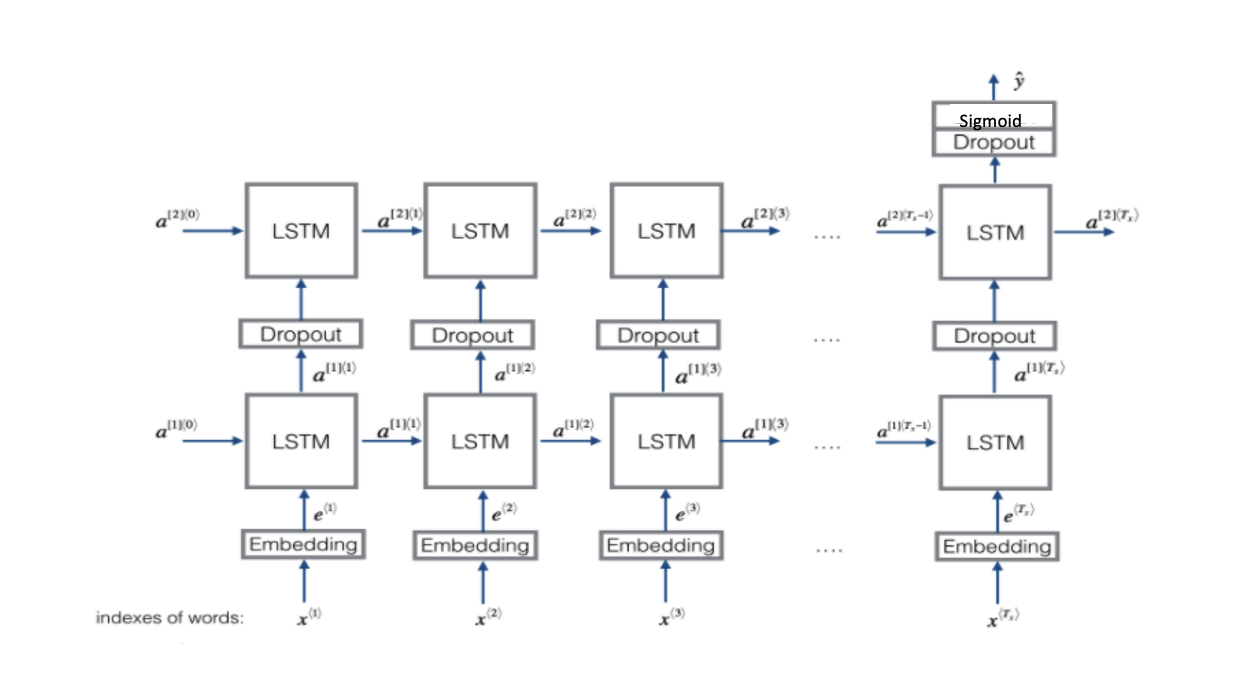

#### Above is our architecure.  We will add all layers in the architecure, but to start we will set dropout to 0.0 to start and try to minimze the training error

In [305]:
def ClickStreamPageModel(input_shape):
    """
    Function creating the click stream model using page names per the graph above
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the model
    name_sentence_indices = Input(shape=input_shape, dtype='int32')
    action_sentence_indicies = Input(shape=input_shape, dtype='int32')
    label_sentence_indicies = Input(shape=input_shape, dtype='int32')
    dwell_sentence_indicies = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layers and propogate the input through these, then append these to create a 55 dimension input
    name_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(name_sentence_indices)
    action_emb = Embedding(input_dim=20001, output_dim=25, trainable=True, mask_zero=True)(action_sentence_indicies)
    label_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(label_sentence_indicies)
    dwell_emb = Embedding(input_dim=12, output_dim=2, trainable=True, mask_zero=True)(dwell_sentence_indicies)
    X = Concatenate()([name_emb, action_emb, label_emb, dwell_emb])
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units=128, return_sequences=True)(X)
    
    # Add dropout with a probability of 0.0
    X = Dropout(rate=0.4)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units=128, return_sequences=False)(X)
    
    # Add dropout with a probability of 0.0
    X = Dropout(rate=0.4)(X) 
    
    # Propagate X through a Dense layer with 1 unit
    X = Dense(units=1)(X)
    # Add a sigmod activation
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[name_sentence_indices, action_sentence_indicies, label_sentence_indicies, dwell_sentence_indicies], outputs=X)
    
    return model

In [306]:
model = ClickStreamPageModel(7)

In [307]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_53 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_54 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_55 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_56 (InputLayer)          [(None, 7)]          0           []                               
                                                                                           

In [308]:
aupr = tensorflow.keras.metrics.AUC(
    num_thresholds=100,
    curve="PR",
    summation_method="interpolation",
    name='aupr',
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False,
)

In [313]:
model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5), metrics=[aupr, 'accuracy'])

In [ ]:
model.fit([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']], 
           y_train, epochs = 100, 
           batch_size = 32, 
           shuffle=True, 
           validation_split=0.5)

Epoch 1/100
 354/8158 [>.............................] - ETA: 7:11 - loss: 0.5248 - aupr: 0.0486 - accuracy: 0.9465

In [ ]:
def print_conversion_metrics(y_true, y_pred_classes, y_pred_probs, title):
    cmtx = pd.DataFrame(
    confusion_matrix(y_true=y_true, y_pred=y_pred_classes), 
                     index=['true: not converted', 'true: converted'], columns=['pred: not converted', 'pred: converted'])
    print(title)
    print(cmtx)
    print('\n')
    print(classification_report(y_true, y_pred_classes))
    print(f'The area under the PR curve is approximately {average_precision_score(y_true, y_pred_probs, pos_label=1):1.2f}')
    

In [ ]:
predictions_train = model.predict(X_train_indicies)
predicted_classes_train = np.where(predictions_train > 0.5, 1, 0)

In [ ]:
print_conversion_metrics(y_train, predicted_classes_train, predictions_train, 'Training Results')

#### Confusion matrix for training  is as expected

#### Now we create the confustion matrix for test

In [ ]:
predictions_test = model.predict(X_test_indicies)
predicted_classes_test = np.where(predictions_test > 0.5, 1, 0)

In [ ]:
print_conversion_metrics(y_test, predicted_classes_test, predictions_test, 'Test Results')